In [1]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from fast_hdbscan.numba_kdtree import NumbaKDTree, kdtree_to_numba, rdist, point_to_node_lower_bound_rdist
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
import umap

In [2]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_100_0_None_None_False'

# model_params = '_75_0_None_None_False'

In [3]:
%%time

### primary chars
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

data = []
for region_id, _ in region_hulls.iterrows():
    region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
    data.append(region_morphotope_data)

data = pd.concat(data)

CPU times: user 19.8 s, sys: 6.73 s, total: 26.6 s
Wall time: 13.7 s


(1046897, 361)

In [7]:
spatial_lag = 3
kernel='gaussian'
lag_type = '_'
lag_dir = '/data/uscuni-ulce/processed_data/lag/'

def read_lag_data(region_id):
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]
    lag_data = pd.read_parquet(f'{lag_dir}{region_id}_{kernel}_lag_{spatial_lag}.parquet')
    lag_data = lag_data.loc[morphotopes.index]
    return lag_data.groupby(morphotopes.morphotope_label).agg('median')

In [ ]:
%%time

from joblib import Parallel, delayed
n_jobs = -1

region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

for region_id, _ in region_hulls.iterrows():
    data = Parallel(n_jobs=n_jobs)(
    delayed(read_lag_data)(region_id) for region_id, _ in region_hulls.iterrows()
)

In [ ]:
1

In [ ]:
df = pd.concat(data)

In [ ]:
data.shape


In [ ]:
data.to_parquet('../data/morh_lag.pq')

In [5]:
# ## read a single region


# # model_params = '_100_3__median_gaussian_False'

# region_id = 69333
# data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
# data.index = str(region_id) + '_' + data.index

In [6]:
### drop noise
data = data[data.index.str[-2:] != '-1']

In [7]:
# data = data.drop(columns=['mibLAL', 'mibCCo'], level=0)

In [8]:
sizes = data.iloc[:, -1]
data = data.iloc[:, :-1]

In [9]:
vals = StandardScaler().fit_transform(data)
component_data = pd.DataFrame(vals, columns=data.columns, index=data.index)
component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)


In [10]:
standardised_data = component_data.copy()

In [11]:
sizes.sort_values(ascending=False).describe().iloc[1:]

mean    177.033752
std      72.752014
min     100.000000
25%     122.000000
50%     156.000000
75%     211.000000
max     903.000000
Name: (Size, Size), dtype: float64

In [12]:
component_data = standardised_data.drop(columns=['percentile_25', 'percentile_75', 'median'], level=1)

In [13]:
component_data.columns.get_level_values(0).unique()

Index(['sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI',
       'ssbElo', 'ssbCCM', 'ssbCCD', 'stbOri', 'mtbSWR', 'libNCo', 'ldbPWL',
       'ltcBuA', 'mtbAli', 'mtbNDi', 'ltbIBD', 'stbCeA', 'stbSAl', 'sdsLen',
       'sssLin', 'ldsMSL', 'ldsRea', 'ldsAre', 'sisBpM', 'sdsSPW', 'sdsSPO',
       'sdsSWD', 'mtdDeg', 'lcdMes', 'linP3W', 'linP4W', 'linPDE', 'lcnClo',
       'lddNDe', 'linWID', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'sddAre', 'midRea',
       'midAre', 'stcOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'mtcWNe',
       'mdcAre', 'ltcWRB', 'sicCAR', 'stcSAl', 'ldkAre', 'ldkPer', 'lskCCo',
       'lskERI', 'lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'sdsAre', 'likWCe',
       'mibCou', 'mibAre', 'mibLen', 'mibElo', 'mibERI', 'mibCCo', 'mibLAL',
       'mibFR', 'mibSCo'],
      dtype='object')

### UMAP embedding

In [16]:
%%capture cap

n_neighbors = 25
umap_metric = 'euclidean'

reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=20, 
                    min_dist=0, negative_sample_rate=50, 
                    metric=umap_metric, verbose=True, random_state=1)

embedding = reducer.fit_transform(component_data.values)


## save the data for later
import joblib
filename = f'../data/umap_morphotopes_model_{n_neighbors}.sav'
joblib.dump(reducer, filename)
pd.DataFrame(embedding, index=data.index).to_parquet(f'../data/umap_embedding_{n_neighbors}.pq')

In [36]:
# %%capture cap

n_neighbors = 10
umap_metric = 'euclidean'

reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=20, 
                    min_dist=0, negative_sample_rate=50, 
                    metric=umap_metric, verbose=True, random_state=1)

embedding = reducer.fit_transform(component_data.values)

# ## save the data for later
# import joblib
# filename = f'../data/umap_morphotopes_model_{n_neighbors}.sav'
# joblib.dump(reducer, filename)
# pd.DataFrame(embedding, index=data.index).to_parquet(f'../data/umap_embedding_{n_neighbors}.pq')

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_components=20, n_jobs=1, n_neighbors=10, negative_sample_rate=50, random_state=1, verbose=True)
Mon Oct 21 15:31:13 2024 Construct fuzzy simplicial set
Mon Oct 21 15:31:14 2024 Finding Nearest Neighbors
Mon Oct 21 15:31:14 2024 Finished Nearest Neighbor Search
Mon Oct 21 15:31:14 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Oct 21 15:31:32 2024 Finished embedding


In [18]:
cap.show()

UMAP(min_dist=0, n_components=20, n_jobs=1, n_neighbors=25, negative_sample_rate=50, random_state=1, verbose=True)
Tue Oct 15 19:37:45 2024 Construct fuzzy simplicial set
Tue Oct 15 19:37:46 2024 Finding Nearest Neighbors
Tue Oct 15 19:37:46 2024 Building RP forest with 58 trees
Tue Oct 15 19:38:57 2024 NN descent for 20 iterations
	 1  /  20
	 2  /  20
	 3  /  20
	 4  /  20
	Stopping threshold met -- exiting after 4 iterations
Tue Oct 15 19:41:17 2024 Finished Nearest Neighbor Search
Tue Oct 15 19:41:23 2024 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Oct 15 22:55:43 2024 Finished embedding
Tue Oct 15 22:56:52 2024 Worst tree score: 0.44794830
Tue Oct 15 22:56:52 2024 Mean tree score: 0.45706307
Tue Oct 15

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epochs completed:   0%|            0/200 [00:00]

In [37]:
component_data = pd.DataFrame(embedding)

In [16]:
# n_neighbors = 25
# component_data = pd.read_parquet(f'../data/umap_embedding_{n_neighbors}.pq')

In [382]:
data

sdbAre                                                     \
             percentile_25      median percentile_75          std        mean   
4_0_0            89.753293  304.015031    672.447645  1431.103767  771.936525   
4_0_1            49.434927  102.553345    189.849041   216.504762  155.019927   
4_0_10           27.028058   68.960581     88.439132   163.867981   81.362610   
4_0_11           25.603623   62.015106    107.289207    56.029793   69.076213   
4_0_12           28.671164   66.469192     99.827722   142.044261   98.664902   
...                    ...         ...           ...          ...         ...   
139096_942_0     60.768806   82.014084    103.611233    35.220537   86.813856   
139096_98_0      55.140986   66.799032     94.722868    42.136212   80.492310   
139096_990_0     67.569904   89.209626    119.133534    42.212625   99.775181   
139096_99_0      64.404242   85.472647    121.811227    61.669700  102.623707   
139096_99_1      67.201210   89.937448    118.569188    64.365580  105.120925   

                    sdbPer                                                 \
             percentile_25     median percentile_75        std       mean   
4_0_0            41.212387  78.247642    124.844977  92.011758  99.806546   
4_0_1            30.456341  43.632330     59.328280  27.024820  48.566208   
4_0_10           23.968276  35.080051     39.866683  28.867460  36.635090   
4_0_11           21.654696  33.516476     42.831315  15.656320  33.787629   
4_0_12           23.672368  35.410784     50.780132  25.085294  40.694432   
...                    ...        ...           ...        ...        ...   
139096_942_0     32.777680  38.559376     44.292407   9.516359  40.016980   
139096_98_0      30.478541  34.651481     39.228122   9.098211  36.341280   
139096_990_0     35.040782  39.612020     47.425902   9.399707  41.775236   
139096_99_0      35.360164  41.116130     47.819640  13.323393  43.377202   
139096_99_1      36.266584  41.589050     48.140580  15.663783  44.717796   

              ...         mibFR                                              \
              ... percentile_25    median percentile_75       std      mean   
4_0_0         ...      3.366838  5.512115     10.150784  5.460149  7.267821   
4_0_1         ...      7.088244  7.088244      7.823093  0.360502  7.376935   
4_0_10        ...      3.039092  3.248108      3.504848  0.546639  3.272880   
4_0_11        ...      2.575245  3.002501      3.388912  0.591115  2.980382   
4_0_12        ...      2.844965  3.457135      3.844932  2.037359  3.819442   
...           ...           ...       ...           ...       ...       ...   
139096_942_0  ...      1.889048  2.126921      2.428820  0.396666  2.176043   
139096_98_0   ...      1.843487  2.079658      2.466595  0.447080  2.178647   
139096_990_0  ...      2.046139  2.338798      2.702140  0.464987  2.391131   
139096_99_0   ...      1.989872  2.270495      2.663066  0.599162  2.381407   
139096_99_1   ...      1.907516  2.257083      2.581685  0.486160  2.289013   

                    mibSCo                                              
             percentile_25    median percentile_75       std      mean  
4_0_0             3.366838  5.512115     10.150784  5.460149  7.267821  
4_0_1             7.088244  7.088244      7.823093  0.360502  7.376935  
4_0_10            3.039092  3.248108      3.504848  0.546639  3.272880  
4_0_11            2.575245  3.002501      3.388912  0.591115  2.980382  
4_0_12            2.844965  3.457135      3.844932  2.037359  3.819442  
...                    ...       ...           ...       ...       ...  
139096_942_0      1.889048  2.126921      2.428820  0.396666  2.176043  
139096_98_0       1.843487  2.079658      2.466595  0.447080  2.178647  
139096_990_0      2.046139  2.338798      2.702140  0.464987  2.391131  
139096_99_0       1.989872  2.270495      2.663066  0.599162  2.381407  
139096_99_1       1.907516  2.257083      2.581685  0.486160

In [17]:
# component_data  = standardised_data

In [18]:
# component_data = component_data.loc[:, component_data.columns[np.arange(1, data.shape[1], 3)]]

In [19]:
# min_cluster_size = 5_000
# sample_weights = sizes.values.astype(np.float32)
# sample_weights[sample_weights > min_cluster_size] = int(min_cluster_size / n_neighbors)

# # min_cluster_size = 50
# # sample_weights = np.ones(sizes.shape[0]).astype(np.float32)

# allow_single_cluster = False

### weighted hsbcan

In [31]:
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (mst_to_linkage_tree_w_sample_weights, 
condense_tree, cluster_tree_from_condensed_tree, extract_eom_clusters,
get_cluster_label_vector, bfs_from_hierarchy, eliminate_branch, CondensedTree, score_condensed_tree_nodes, eom_recursion)
from sklearn.neighbors import KDTree

In [32]:
# from fast_hdbscan import fast_hdbscan
# res = fast_hdbscan(component_data.values, sample_weights=sample_weights.astype(np.float32), min_samples=min_cluster_size, min_cluster_size=min_cluster_size , return_trees=True)

In [33]:
# min_samples = 10

min_samples = min_cluster_size

NameError: name 'min_cluster_size' is not defined

In [45]:
%%time

## hdbscan kdtree
sklearn_tree = KDTree(component_data.values)
numba_tree = kdtree_to_numba(sklearn_tree)

edges = parallel_boruvka(
    numba_tree,
    min_samples=min_samples,
    sample_weights=sample_weights,
)
sorted_mst = edges[np.argsort(edges.T[2])]

linkage_tree = mst_to_linkage_tree_w_sample_weights(sorted_mst, sample_weights)

CPU times: user 9min 28s, sys: 634 ms, total: 9min 28s
Wall time: 33.2 s


In [16]:
### agglomerative clustering tree
def get_linkage_matrix_sizes(model, sizes=None):
    """" Create a linkage matrix from a sklearn hierarchical clustering model.
    Requires the full tree and the distances stored in the model instance.
    If sizes is None, by default every sample has weight 1"""

    if sizes is None:
        sizes = np.ones(model.labels_.shape[0])
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += sizes[child_idx]  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

In [81]:
# ### agglomerative clustering tree

# linkage = 'ward'
# metric = 'euclidean'
# sklearn_linkage_structure = namedtuple('Model', ['children_', 'labels_', 'distances_'])


# from sklearn.cluster import AgglomerativeClustering
# clusterer = AgglomerativeClustering(linkage=linkage,
#                                     metric=metric,
#                                     compute_full_tree=True,
#                                     compute_distances=True)
# model = clusterer.fit(component_data.values[sizes > 100])
# linkage_tree = get_linkage_matrix_sizes(model, sizes=None)

In [48]:
### tests against hdbscan linkage tree

# m = sklearn_linkage_structure(linkage_tree[:, [0, 1]].astype(int),
#                               np.ones(component_data.shape[0]),
#                               linkage_tree[:, 2])

# l = get_linkage_matrix_sizes(m, sizes=sample_weights)
# assert np.allclose(l, linkage_tree)

# l1 = get_linkage_matrix(model)
# l2 = get_linkage_matrix_sizes(model)
# assert np.allclose(l1, l2)

In [49]:
# min_cluster_size = 250_000

In [50]:
@numba.njit(fastmath=True)
def condense_tree(hierarchy, min_cluster_size=10, bandwidth=1, sample_weights=None):
    root = 2 * hierarchy.shape[0]
    num_points = hierarchy.shape[0] + 1
    next_label = num_points + 1

    node_list = bfs_from_hierarchy(hierarchy, root, num_points)

    relabel = np.zeros(root + 1, dtype=np.int64)
    relabel[root] = num_points

    parents = np.ones(root, dtype=np.int64)
    children = np.empty(root, dtype=np.int64)
    lambdas = np.empty(root, dtype=np.float32)
    sizes = np.ones(root, dtype=np.int64)

    ignore = np.zeros(root + 1, dtype=np.bool_) # 'bool' is no longer an attribute of 'numpy'

    if sample_weights is None:
        sample_weights = np.ones(num_points, dtype=np.float32)

    idx = 0

    for node in node_list:
        if ignore[node] or node < num_points:
            continue

        parent_node = relabel[node]
        l, r, d, _ = hierarchy[node - num_points]
        left = np.int64(l)
        right = np.int64(r)
        if d > 0.0:
            # gaussian lambda value
            # lambda_value = np.exp(-(((d / bandwidth) / 2) ** 2)) / (np.sqrt(2) * np.pi)
            lambda_value = 1.0 / d
        else:
            lambda_value = np.inf

        left_count = np.int64(hierarchy[left - num_points, 3]) if left >= num_points else sample_weights[left]
        right_count = np.int64(hierarchy[right - num_points, 3]) if right >= num_points else sample_weights[right]

        # The logic here is in a strange order, but it has non-trivial performance gains ...
        # The most common case by far is a singleton on the left; and cluster on the right take care of this separately
        if left < num_points and right_count >= min_cluster_size:
            relabel[right] = parent_node
            parents[idx] = parent_node
            children[idx] = left
            lambdas[idx] = lambda_value
            idx += 1
        # Next most common is a small left cluster and a large right cluster: relabel the right node; eliminate the left branch
        elif left_count < min_cluster_size and right_count >= min_cluster_size:
            relabel[right] = parent_node
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # Then we have a large left cluster and a small right cluster: relabel the left node; elimiate the right branch
        elif left_count >= min_cluster_size and right_count < min_cluster_size:
            relabel[left] = parent_node
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # If both clusters are small then eliminate all branches
        elif left_count < min_cluster_size and right_count < min_cluster_size:
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # and finally if we actually have a legitimate cluster split, handle that correctly
        else:
            relabel[left] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = left_count
            next_label += 1
            idx += 1

            relabel[right] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = right_count
            next_label += 1
            idx += 1

    return CondensedTree(parents[:idx], children[:idx], lambdas[:idx], sizes[:idx])

In [51]:
from scipy.stats import gaussian_kde
e = gaussian_kde(sorted_mst[:, 2])
f = e.covariance_factor()
bw = f * linkage_tree[:, 2].std()
bw

np.float64(0.009027899389063818)

In [52]:
condensed_tree = condense_tree(linkage_tree, 
                               min_cluster_size=min_cluster_size,
                               bandwidth=.02,
                               sample_weights=sample_weights)

In [53]:
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)

In [54]:
@numba.njit()
def score_condensed_tree_nodes(condensed_tree):
    result = {0: np.float64(0.0) for i in range(0)}

    for i in range(condensed_tree.parent.shape[0]):
        parent = condensed_tree.parent[i]
        if parent in result:
            result[parent] += condensed_tree.lambda_val[i] * condensed_tree.child_size[i]
        else:
            result[parent] = condensed_tree.lambda_val[i] * condensed_tree.child_size[i]

        if condensed_tree.child_size[i] > 1:
            child = condensed_tree.child[i]
            if child in result:
                result[child] -= condensed_tree.lambda_val[i] * condensed_tree.child_size[i]
            else:
                result[child] = -condensed_tree.lambda_val[i] * condensed_tree.child_size[i]

    return result

@numba.njit()
def extract_eom_clusters(condensed_tree, cluster_tree, allow_single_cluster=False):
    node_scores = score_condensed_tree_nodes(condensed_tree)
    selected_clusters = {node: False for node in node_scores}

    if len(cluster_tree.parent) == 0:
        return np.zeros(0, dtype=np.int64)

    cluster_tree_root = cluster_tree.parent.min()

    if allow_single_cluster:
        eom_recursion(cluster_tree_root, cluster_tree, node_scores, selected_clusters)
    elif len(node_scores) > 1:
        root_children = cluster_tree.child[cluster_tree.parent == cluster_tree_root]
        for child_node in root_children:
            eom_recursion(child_node, cluster_tree, node_scores, selected_clusters)

    return np.asarray([node for node, selected in selected_clusters.items() if selected])

In [55]:
selected_clusters = extract_eom_clusters(condensed_tree, cluster_tree, allow_single_cluster=allow_single_cluster)

In [56]:
# from fast_hdbscan.cluster_trees import extract_leaves
# selected_clusters = extract_leaves(
#             condensed_tree, allow_single_cluster=False
# )

In [57]:
clusters = get_cluster_label_vector(
        condensed_tree,
        selected_clusters,
        0,
        n_samples=data.shape[0],
    )
pd.Series(clusters).value_counts()

 28    502552
 29    261012
 21    112475
 24    110228
 23     42909
 26     39380
 27     15145
 11     12965
 16      7699
 3       6069
 8       5099
 25      4965
 10      4112
 15      3207
 9       2498
 18      2100
 17      1126
 6        465
 4        406
 19       211
 12       194
 1        175
 14       168
 20       150
-1        122
 13        94
 22        85
 2         76
 7         60
 5         57
 0         57
Name: count, dtype: int64

In [58]:
pd.Series(linkage_tree[:, 2]).describe().iloc[1:]

mean     0.531443
std      0.146775
min      0.023269
25%      0.453193
50%      0.533837
75%      0.606297
max     22.417928
dtype: float64

In [59]:
# from fast_hdbscan.cluster_trees import get_cluster_labelling_at_cut
# clusters = get_cluster_labelling_at_cut(linkage_tree, .5, 100)
# pd.Series(clusters).value_counts()

## Kmeans

In [14]:
cols = standardised_data.columns.get_level_values(0).unique()
to_drop = cols[cols.str.startswith('s')][:-3]
# to_drop = cols[cols.str[2] == 'n'] # drop all network chars
# component_data = standardised_data.drop(columns=to_drop, level=0)

# to_drop

In [15]:
# to_drop = cols[~cols.isin(['sdbAre', 'sdsSPW', 'mibAre'])]

In [16]:
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
# 'sdbAre', 'ssbCCM', 'sdcLAL'
    # 'mibCCo', 'mibLAL'
]

In [17]:
## add iqr
res = data.xs('percentile_75', level=1, axis=1) - data.xs('percentile_25', level=1, axis=1)
res = res.drop(to_drop, axis='columns')
res.columns = [col + '_iqr' for col in res.columns]


vals = StandardScaler().fit_transform(res)
component_data = pd.DataFrame(vals, columns=res.columns, index=res.index)
component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
res = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

res

,sdbAre_iqr,sdbPer_iqr,sdbCoA_iqr,ssbCCo_iqr,ssbCor_iqr,ssbSqu_iqr,ssbERI_iqr,ssbElo_iqr,ssbCCM_iqr,ssbCCD_iqr,...,sdsAre_iqr,mibCou_iqr,mibAre_iqr,mibLen_iqr,mibElo_iqr,mibERI_iqr,mibCCo_iqr,mibLAL_iqr,mibFR_iqr,mibSCo_iqr
4_0_0,5.128804,4.405082,-0.005904,2.833233,-1.739406,-0.308079,-1.597017,3.988743,0.000000,0.000000,...,-0.546072,-0.123745,0.887632,0.232987,1.592490,-0.863792,0.676116,0.786634,6.740778,6.740778
4_0_1,0.409684,0.299177,-0.005904,1.365858,-0.618351,0.184744,-0.648369,0.607900,0.554823,0.202646,...,-0.468843,6.437179,0.147968,-0.106241,-1.965881,-1.778024,-2.886519,-0.180029,-0.541832,-0.541832
4_0_10,-0.433277,-0.673566,-0.005904,0.331799,0.502705,-0.349390,-0.618251,-0.634815,-0.644195,-0.324237,...,-0.304378,4.051388,0.244617,0.440374,-1.258089,-0.058588,0.229398,1.308770,-0.865797,-0.865797
4_0_11,-0.216949,-0.277811,-0.005904,-0.469231,0.502705,-0.352185,-0.417598,0.116940,-0.125336,-0.215240,...,-0.307788,0.472702,-0.043983,-0.021149,1.411631,0.294515,0.031339,0.035199,-0.446942,-0.446942
4_0_12,-0.329293,0.166901,-0.005904,0.332366,-0.618351,-0.137597,-0.105252,-0.882660,-0.133221,-0.081635,...,-0.277561,1.367374,0.047249,0.108037,0.748789,0.389091,0.106386,0.374907,-0.222652,-0.222652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139096_942_0,-0.631404,-1.002251,-0.005904,-0.324349,-1.739406,-0.414224,-1.454970,-0.826480,-0.717015,-1.738077,...,0.302131,-0.720193,-0.167754,-0.179814,-0.562538,-1.869378,-1.034260,-0.386093,-0.776688,-0.776688
139096_98_0,-0.666194,-1.209579,-0.005904,-1.613041,-1.739406,-0.523406,-1.616234,-1.299926,-1.038423,-1.866453,...,-0.546072,-0.720193,-0.172986,-0.193273,-1.215554,-1.945565,-2.164069,-0.445353,-0.676359,-0.676359
139096_990_0,-0.538349,-0.936989,-0.005904,-0.013958,-1.739406,-0.539647,-1.615635,-1.011706,-0.503538,-1.875620,...,0.348966,-0.720193,-0.163407,-0.176191,-0.611821,-1.948659,-0.807335,-0.369164,-0.636758,-0.636758
139096_99_0,-0.476001,-0.931414,-0.005904,-0.124104,-0.618351,-0.506801,0.626516,0.509533,-0.565487,0.450687,...,-0.032815,-0.720193,-0.155989,-0.158216,1.074833,-0.920884,-0.356970,-0.334587,-0.616059,-0.616059


In [18]:
component_data = standardised_data.drop(columns=['percentile_25', 'percentile_75', 'mean'], level=1)
# component_data = standardised_data.drop(columns=['mean'], level=1)

# component_data = standardised_data

In [19]:
component_data = component_data.drop(
    columns=to_drop, level=0)

In [20]:
component_data.columns =  ['_'.join(col).strip() for col in component_data.columns.values]

In [21]:
# component_data = component_data.join(res)

In [22]:
component_data.columns

Index(['sdbAre_median', 'sdbAre_std', 'sdbPer_median', 'sdbPer_std',
       'sdbCoA_median', 'sdbCoA_std', 'ssbCCo_median', 'ssbCCo_std',
       'ssbCor_median', 'ssbCor_std',
       ...
       'mibERI_median', 'mibERI_std', 'mibCCo_median', 'mibCCo_std',
       'mibLAL_median', 'mibLAL_std', 'mibFR_median', 'mibFR_std',
       'mibSCo_median', 'mibSCo_std'],
      dtype='object', length=118)

In [23]:
%%time

## k-256, mean and std split the big blocks into at least 2 clusters... but mala strana is messed up
from sklearn.cluster import KMeans, MiniBatchKMeans
kmeans_clusterer = KMeans(n_clusters=256, max_iter=500, random_state=123)
kmeans_clusters = kmeans_clusterer.fit(component_data).labels_
kmeans_cluster_sizes = sizes.groupby(kmeans_clusters).sum().sort_index()

CPU times: user 5min 52s, sys: 277 ms, total: 5min 52s
Wall time: 34.6 s


In [24]:
pd.Series(kmeans_clusters).value_counts().describe()

count     256.000000
mean     1391.921875
std      1137.050547
min         1.000000
25%       392.500000
50%      1231.000000
75%      2155.500000
max      4726.000000
Name: count, dtype: float64

In [25]:
kmeans_cluster_sizes.describe()

count       256.000000
mean     246417.152344
std      211197.142869
min         101.000000
25%       70328.000000
50%      195415.000000
75%      367287.750000
max      883667.000000
Name: (Size, Size), dtype: float64

In [26]:

linkage = 'ward'
metric = 'euclidean'
sklearn_linkage_structure = namedtuple('Model', ['children_', 'labels_', 'distances_'])


from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
clusterer = AgglomerativeClustering(linkage=linkage,
                                    metric=metric,
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(kmeans_clusterer.cluster_centers_)
linkage_matrix = get_linkage_matrix(model)

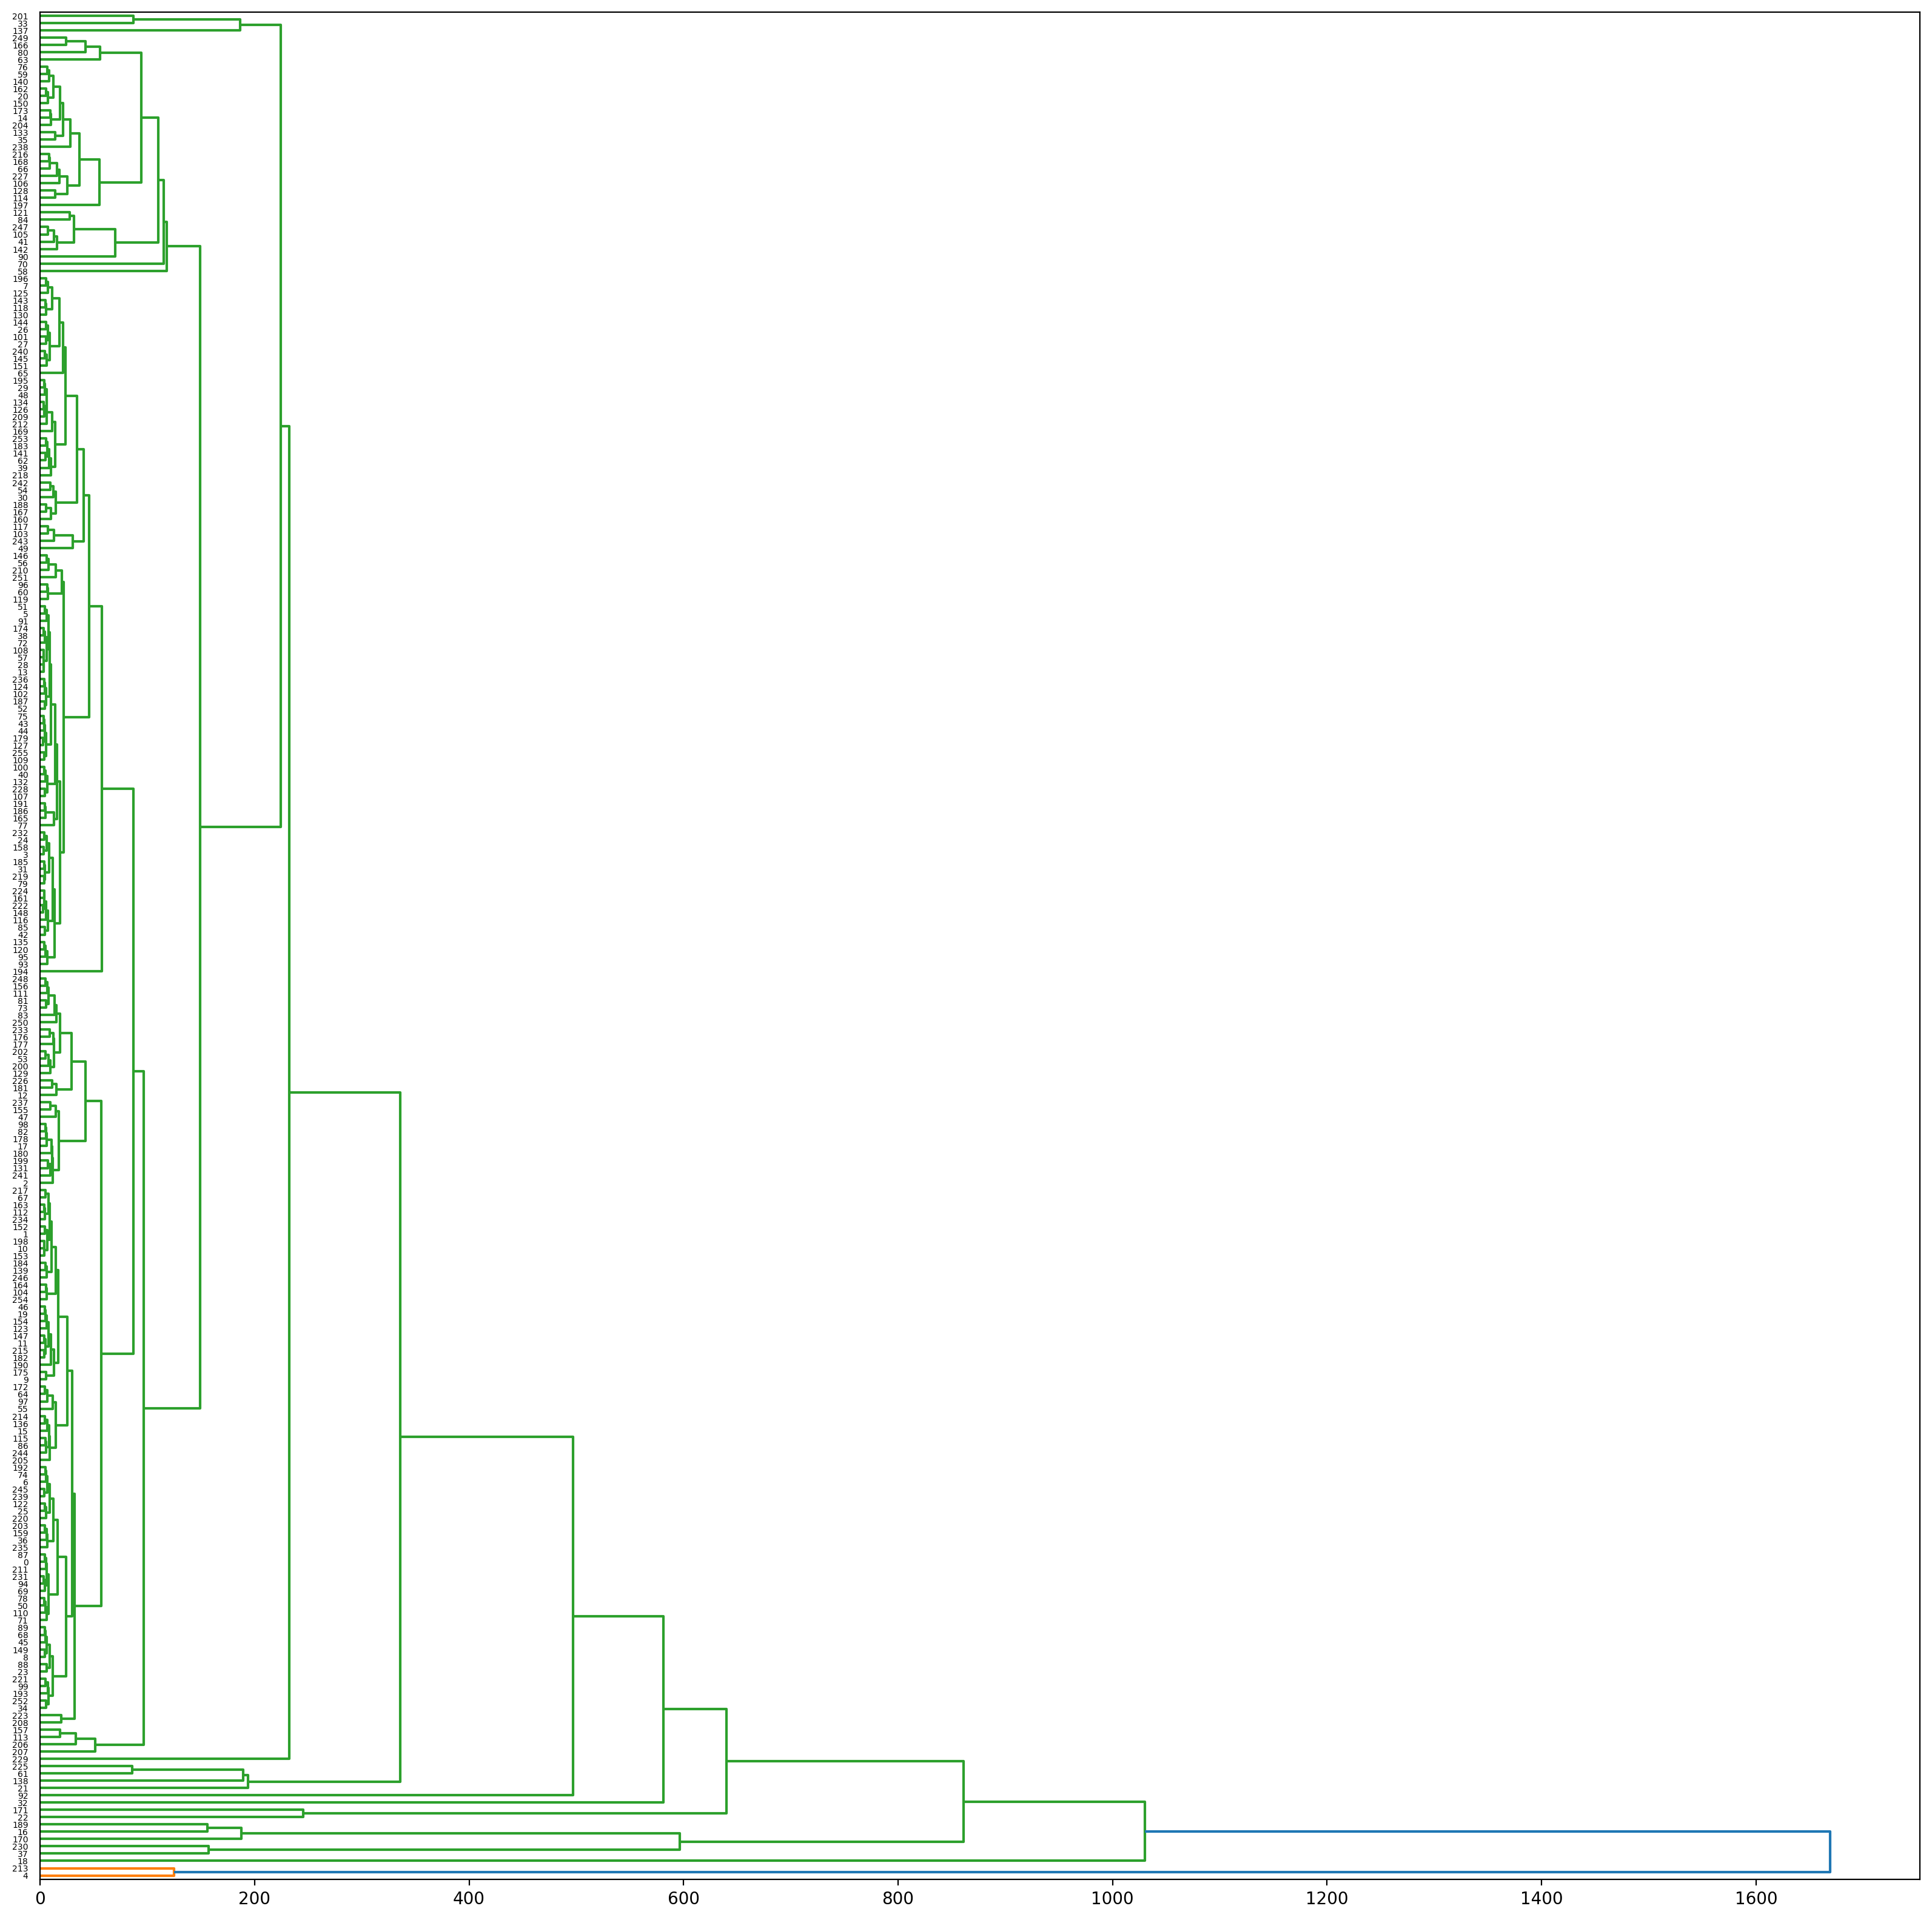

In [27]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster
from hdbscan.plots import SingleLinkageTree

fig,ax = plt.subplots(figsize=(20,20), dpi=200)
_ = dendrogram(linkage_matrix, ax=ax, orientation='right')

# fig, ax = plt.subplots(figsize=(20,10))
# SingleLinkageTree(linkage_matrix).plot(axis=ax)

In [28]:
cutoff = 1.25

In [29]:
ward_clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
ward_clusters = pd.Series(ward_clusters, index=np.arange(np.unique(kmeans_clusters).shape[0]))
np.unique(ward_clusters)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [30]:
clusters = pd.Series(kmeans_clusters).map(lambda x: ward_clusters.loc[x]).values

In [31]:
clusters = kmeans_clusters.copy()

In [32]:
region_id = 69333


etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')
etcs['label'] = -1

morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

region_clusters = pd.Series(clusters, data.index)[data.index.str.startswith(str(region_id))]
region_clusters.index = region_clusters.index.str.slice(len(str(region_id)) + 1, )
region_clusters

1005_0      6
1016_0      0
1016_1     87
1016_2     50
1018_0    226
         ... 
978_0      87
979_0      15
991_0      69
997_0       6
9_0         6
Length: 1988, dtype: int32

In [33]:
region_clusters.nunique()

138

In [34]:
region_clusters.value_counts()

87     171
50     147
6      130
231    104
203     96
      ... 
54       1
97       1
147      1
133      1
224      1
Name: count, Length: 138, dtype: int64

In [42]:
%%time
## assign morphotope clusters to tess cells

etcs.loc[morphotopes.index, 'label'] = morphotopes.morphotope_label.map(lambda x: region_clusters.loc[x] if x in region_clusters.index else -1).values



CPU times: user 1.06 s, sys: 61 μs, total: 1.06 s
Wall time: 1.06 s


In [46]:
%%time
# # # relabel morphotopes for plotting
morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
etcs['morph'] = '-1'
etcs.loc[morphotopes.index, 'morph'] = morphotopes.values

CPU times: user 1.35 s, sys: 2.08 ms, total: 1.35 s
Wall time: 1.35 s


In [47]:
etcs.label.value_counts()

label
 4650    14047
-1        4256
 442      2519
 1396     1670
 2859      898
         ...  
 3880        1
 883         1
 882         1
 873         1
 869         1
Name: count, Length: 5414, dtype: int64

In [48]:
layer.get_fill_color = get_color(etcs.label)

In [38]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 6.95 s, sys: 464 ms, total: 7.42 s
Wall time: 7.43 s


In [39]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [40]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(etcs.label)

In [41]:
1

1

In [128]:
target_cluster = 158
etcs[etcs.label == target_cluster].shape

(708, 3)

In [157]:
# 
# etcs[etcs.label == target_cluster].explore()

In [130]:
# only_medians = standardised_data.loc[:, data.columns[np.arange(1, data.shape[1], 3)]]

In [48]:
x = component_data[clusters == 205].mean() # josefov
y = component_data[clusters == 53].mean() # vinohrady
z = component_data[clusters == 128].mean() # some other houses

In [47]:
np.sqrt(((x - y)**2).sum()), np.sqrt(((y - z)**2).sum())

(np.float64(0.0), np.float64(0.0))

In [45]:
(x-y).iloc[(x - y).abs().argsort().values[::-1]].iloc[:25]

/tmp/ipykernel_3056931/3152660663.py:1: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  (x-y).iloc[(x - y).abs().argsort().values[::-1]].iloc[:25]


mibSCo  mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
dtype: float64

In [46]:
(y - z).iloc[(y - z).abs().argsort().values[::-1]].iloc[:25]

/tmp/ipykernel_3056931/4092641873.py:1: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  (y - z).iloc[(y - z).abs().argsort().values[::-1]].iloc[:25]


mibSCo  mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
        mean   NaN
dtype: float64

In [ ]:
# why is 849_182 closer to 849_235, rather than 849_486, 

In [131]:
x = component_data.loc['69333_849_236'] # karlin offices
y = component_data.loc['69333_849_182'] # zelena liska
z = component_data.loc['69333_849_486'] # chodov

np.sqrt(((x - y)**2).sum()), np.sqrt(((y - z)**2).sum())

(np.float64(7.108953055413817), np.float64(8.355743393339335))

In [132]:
(x-y).iloc[(x - y).abs().argsort().values[::-1]].iloc[:25]

sdcAre_median    4.768575
mdcAre_median    2.606511
ssbCor_median    1.794722
ssbERI_median   -1.717835
ssbCCD_median    1.606935
mibElo_median    1.309370
mtbNDi_median    1.302262
linPDE_median    1.189007
mibCCo_median    1.156835
ssbCCo_median    0.859441
sscCCo_median    0.826191
ssbElo_median    0.818841
sdbPer_median    0.796187
ltcBuA_median    0.727909
sicCAR_median   -0.700639
linP3W_median   -0.643725
lcdMes_median   -0.538028
sscERI_median   -0.533751
ltbIBD_median    0.509030
linP4W_median   -0.506302
mtbAli_median    0.385966
sdsSPO_median    0.344521
lddNDe_median    0.343318
sdsSWD_median    0.311904
mtcWNe_median   -0.291199
dtype: float64

In [133]:
(y - z).iloc[(y - z).abs().argsort().values[::-1]].iloc[:25]

ssbCCD_median   -4.216972
ssbERI_median    3.139262
sdcAre_median   -2.810136
sdbPer_median   -2.168425
lcdMes_median    1.967280
mdcAre_median   -1.936156
linPDE_median   -1.849566
mibCCo_median   -1.776037
mibElo_median   -1.575822
ssbCCo_median   -1.519666
mtbAli_median    1.451853
linP3W_median    1.350915
sscCCo_median   -1.300157
ssbElo_median   -0.975749
ltbIBD_median   -0.896046
mtbNDi_median   -0.892608
ltcBuA_median   -0.727909
mibFR_median    -0.484671
mibSCo_median   -0.484671
sscERI_median   -0.464242
linP4W_median    0.455232
ltcWRB_median    0.407720
linWID_median    0.389139
sicCAR_median    0.366048
ldsCDL_median   -0.339707
dtype: float64

In [134]:
(x - z).iloc[(x - z).abs().argsort().values[::-1]].iloc[:25]

ssbCCD_median   -2.610037
sdcAre_median    1.958439
mtbAli_median    1.837819
ssbCor_median    1.794722
lcdMes_median    1.429252
ssbERI_median    1.421428
sdbPer_median   -1.372238
sscERI_median   -0.997993
linP3W_median    0.707191
mdcAre_median    0.670355
linPDE_median   -0.660559
ssbCCo_median   -0.660226
mibCCo_median   -0.619201
sdsSPO_median    0.509688
sscCCo_median   -0.473966
ssbSqu_median    0.456776
linWID_median    0.432817
mtbNDi_median    0.409654
ltbIBD_median   -0.387016
mibFR_median    -0.361980
mibSCo_median   -0.361980
sicCAR_median   -0.334591
lddNDe_median    0.313226
mibElo_median   -0.266453
sdsSWD_median    0.189816
dtype: float64

### Tree plotting

In [129]:
ct = condensed_tree

In [130]:
ct_raw = np.rec.fromarrays((ct[0], ct[1], ct[2], ct[3]),
         dtype=[('parent', np.intp),('child', np.intp),('lambda_val', float),('child_size', np.intp)])

In [540]:
from hdbscan.plots import CondensedTree
import matplotlib.pyplot as plt

In [541]:
# fig,ax = plt.subplots(figsize=(20,10))
# CondensedTree(ct_raw).plot(colorbar=False)

<Axes: ylabel='distance'>

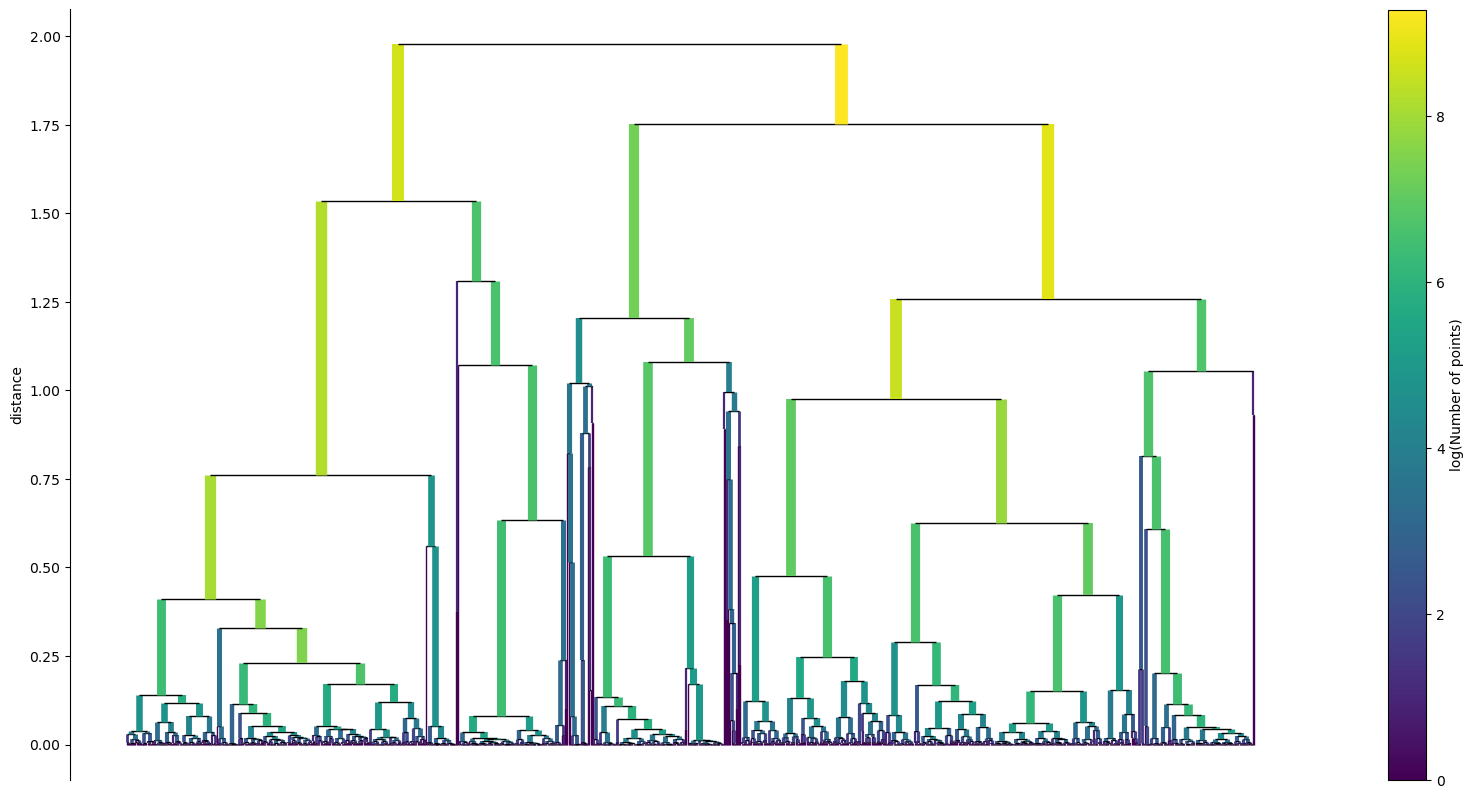

In [543]:
from hdbscan.plots import SingleLinkageTree
fig, ax = plt.subplots(figsize=(20,10))
SingleLinkageTree(linkage_matrix).plot(axis=ax)

In [123]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca_reducer = PCA(n_components=3)
pca_embedding = pca_reducer.fit_transform(component_data)

/tmp/ipykernel_2911159/3759342808.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


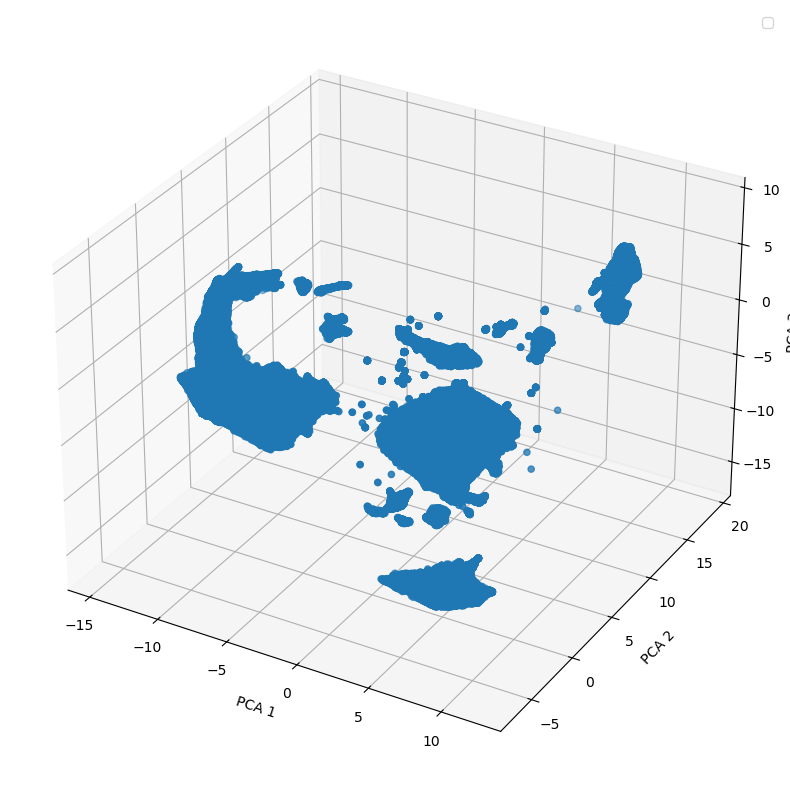

In [124]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pca_embedding[:, 0], pca_embedding[:, 1], pca_embedding[:, 2])
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.legend()

Text(0.5, 0, 'UMAP 3')

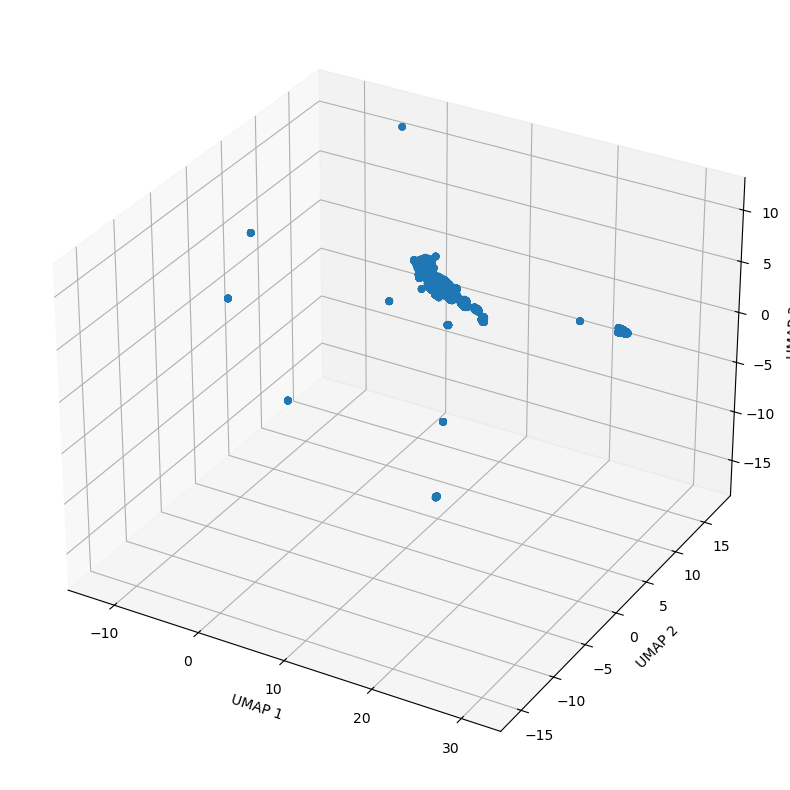

In [125]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")

In [547]:
plotting_data = component_data.sample(100_000)

In [602]:
europe = gpd.read_file('../data/Europe.zip').to_crs(epsg=3035)
region_hulls['country'] = 'None'

In [607]:
inpt, tree = region_hulls.sindex.query(europe.geometry, predicate='covers')
region_hulls.iloc[tree, -1] = europe.iloc[inpt, 0]
plotting_labels = region_hulls.loc[plotting_data.index.str.split('_').str[0].astype(int), 'country']

In [609]:
plotting_labels.unique()

array(['None', 'DEU', 'CZE', 'POL', 'SVK'], dtype=object)

UMAP(n_neighbors=10, verbose=True)
Wed Oct 16 14:31:34 2024 Construct fuzzy simplicial set
Wed Oct 16 14:31:34 2024 Finding Nearest Neighbors
Wed Oct 16 14:31:34 2024 Building RP forest with 21 trees
Wed Oct 16 14:31:35 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Wed Oct 16 14:31:39 2024 Finished Nearest Neighbor Search
Wed Oct 16 14:31:40 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Oct 16 14:32:03 2024 Finished embedding


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc 

CPU times: user 6min 30s, sys: 9.04 s, total: 6min 39s
Wall time: 31.9 s


<Axes: >

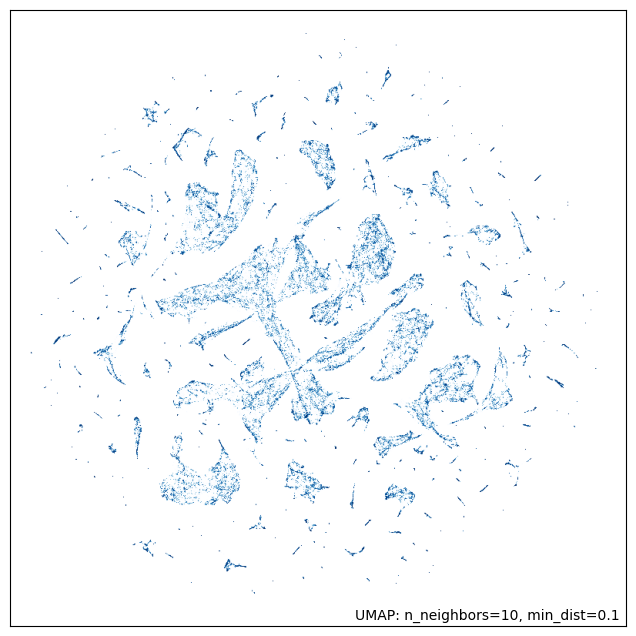

In [597]:
%%time
n_neighbors = 10
umap_metric = 'euclidean'

reducer = umap.UMAP(n_neighbors=10, n_components=2, metric=umap_metric, verbose=True)
embedding = reducer.fit_transform(component_data.sample(100_000))


<Axes: >

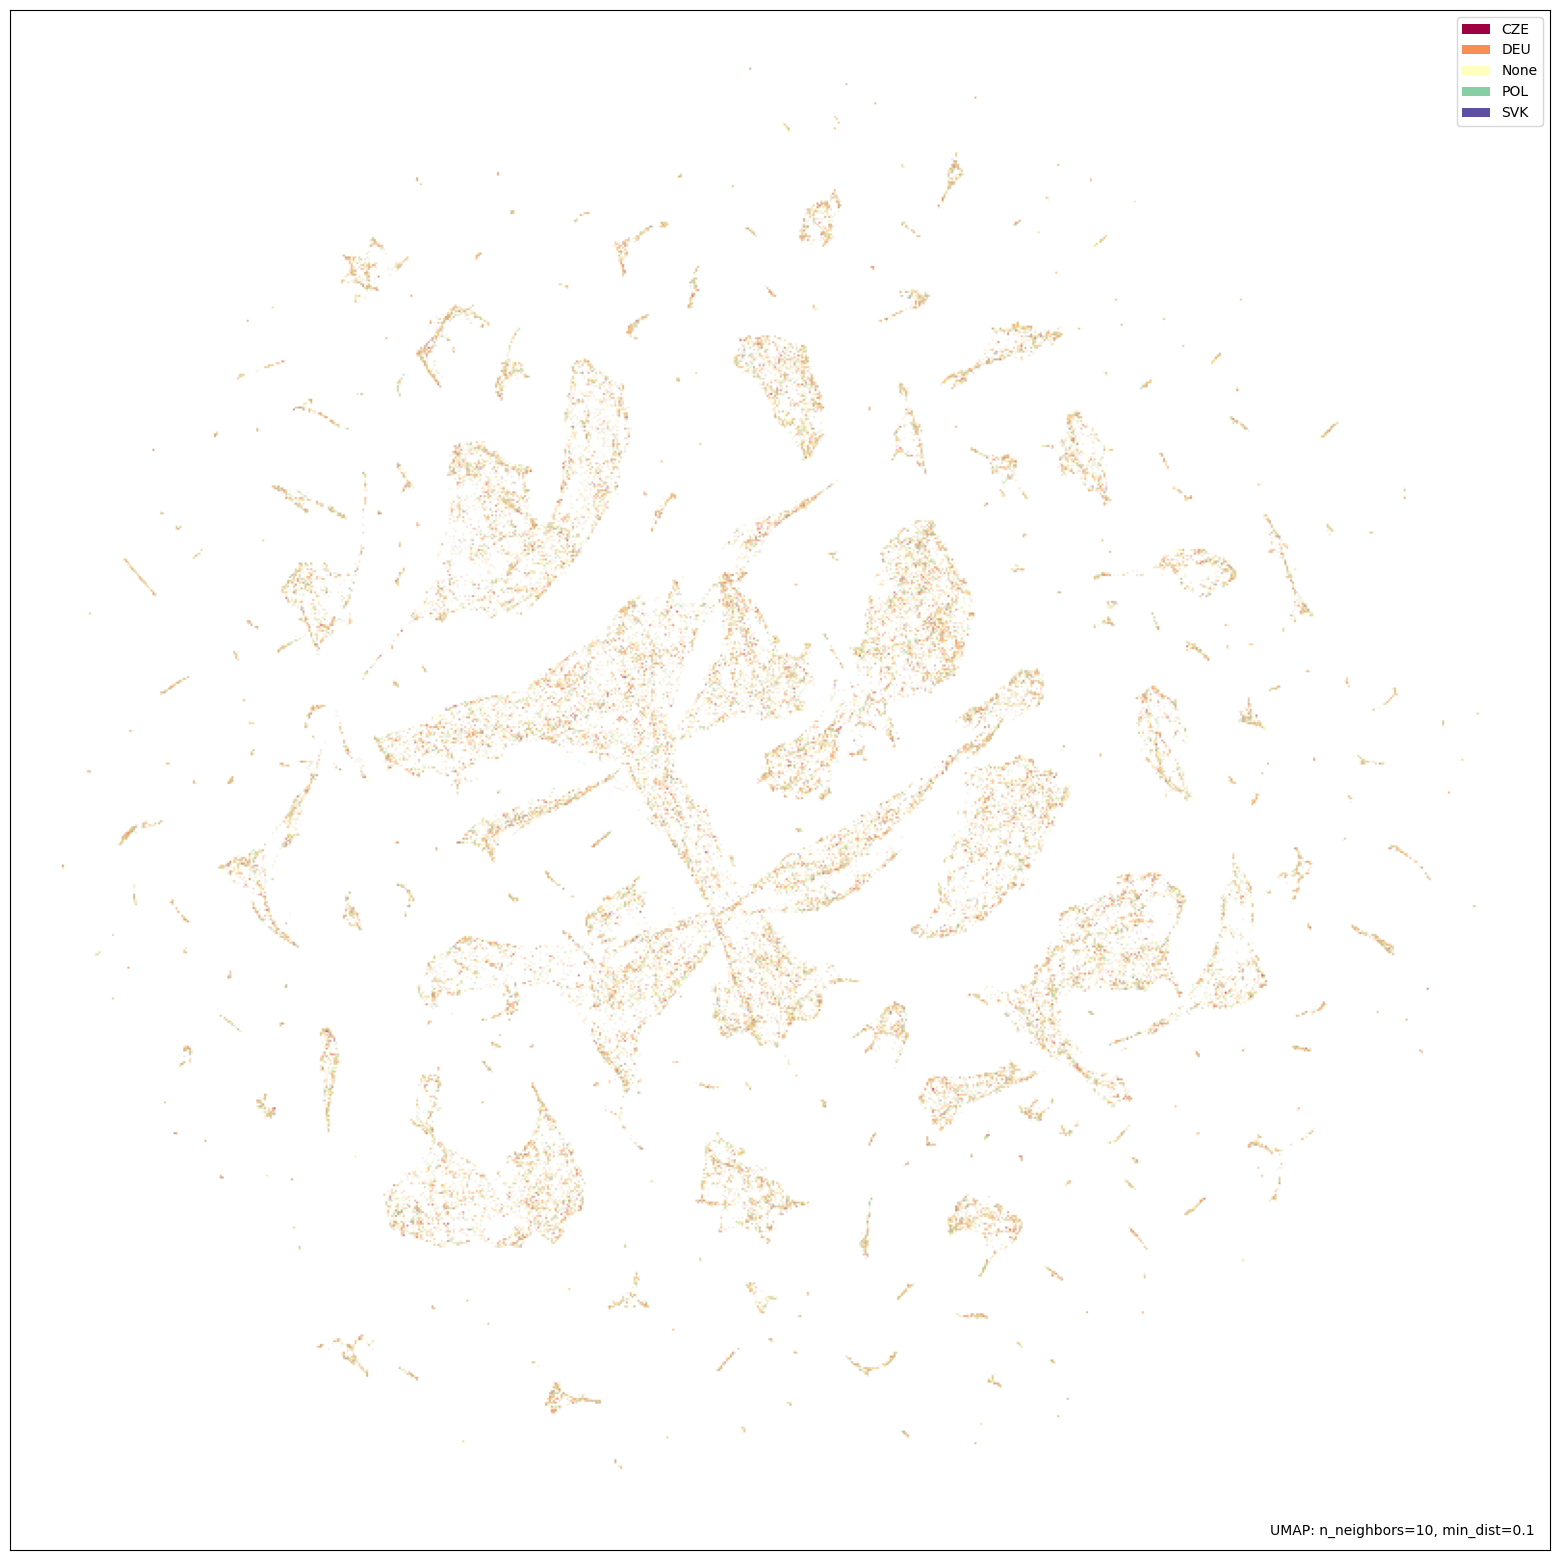

In [610]:
import umap.plot
fig, ax = plt.subplots(figsize=(20,20))
umap.plot.points(reducer, labels=plotting_labels, ax=ax)